In [2]:
# PROJECT PROGRESS 5: MODEL EVALUATION
# FEATURES: Confusion Matrix, Classification Report

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# The 4 Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv('C:\\Python\\ObesityDataSet_raw_and_data_sinthetic.csv')
df = df.dropna()
df.rename(columns={'FAVC': 'HighCaloricFood', 'NObeyesdad': 'ObesityLevel'}, inplace=True)

# Encoding (Text -> Numbers)
le_target = LabelEncoder()
# Encode Target
df['ObesityLevel_Encoded'] = le_target.fit_transform(df['ObesityLevel'])

# Encode All Text Columns
le_features = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = le_features.fit_transform(df[col])

# Normalization (Crucial for SVM and Logistic Regression)
scaler = MinMaxScaler()
feature_cols = df.columns.drop(['ObesityLevel', 'ObesityLevel_Encoded'])
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [5]:
# Split Data FIRST
X = df.drop(['ObesityLevel', 'ObesityLevel_Encoded'], axis=1)
y = df['ObesityLevel_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# THEN Scale
scaler = MinMaxScaler()
# Fit ONLY on training data
X_train = scaler.fit_transform(X_train)
# Transform test data using training stats
X_test = scaler.transform(X_test)

# Initialize the 4 Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train Loop
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Random Forest...
Training XGBoost...
Training SVM...
Training Logistic Regression...


Random Forest Accuracy: 95.0355%
XGBoost Accuracy: 95.5083%
SVM Accuracy: 83.2151%
Logistic Regression Accuracy: 73.7589%


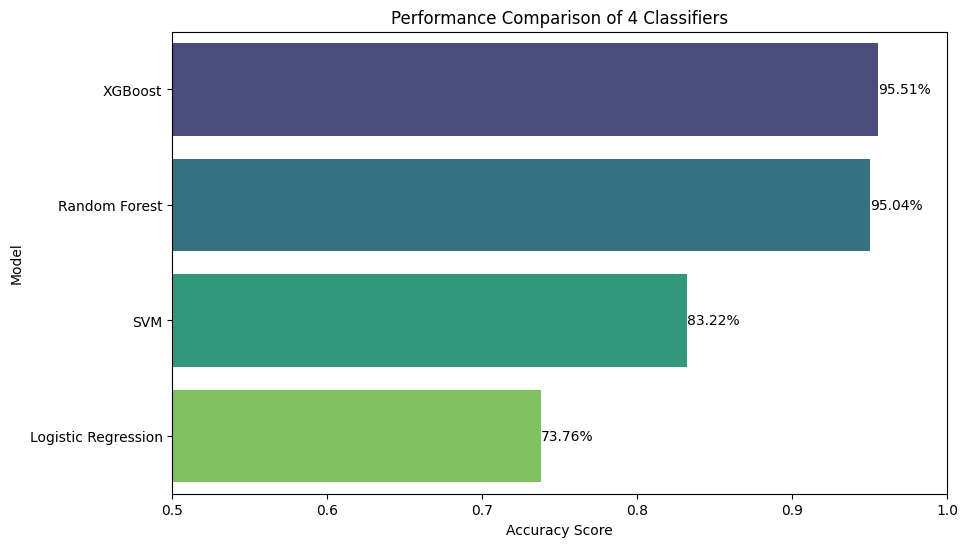

In [6]:
# MODEL EVALUATION & COMPARISON
results = []

# Evaluate Loop
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"{name} Accuracy: {acc:.4%}")

# Convert results to Table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# Bar Chart Comparison
plt.figure(figsize=(10, 6))
# Using 'hue' to fix the warning
sns.barplot(x='Accuracy', y='Model', hue='Model', data=results_df, palette='viridis', legend=False)
plt.xlim(0.5, 1.0) # Zoom in on the 50%-100% range to see differences
plt.title('Performance Comparison of 4 Classifiers')
plt.xlabel('Accuracy Score')
for index, value in enumerate(results_df['Accuracy']):
    plt.text(value, index, f'{value:.2%}', va='center')
plt.show()

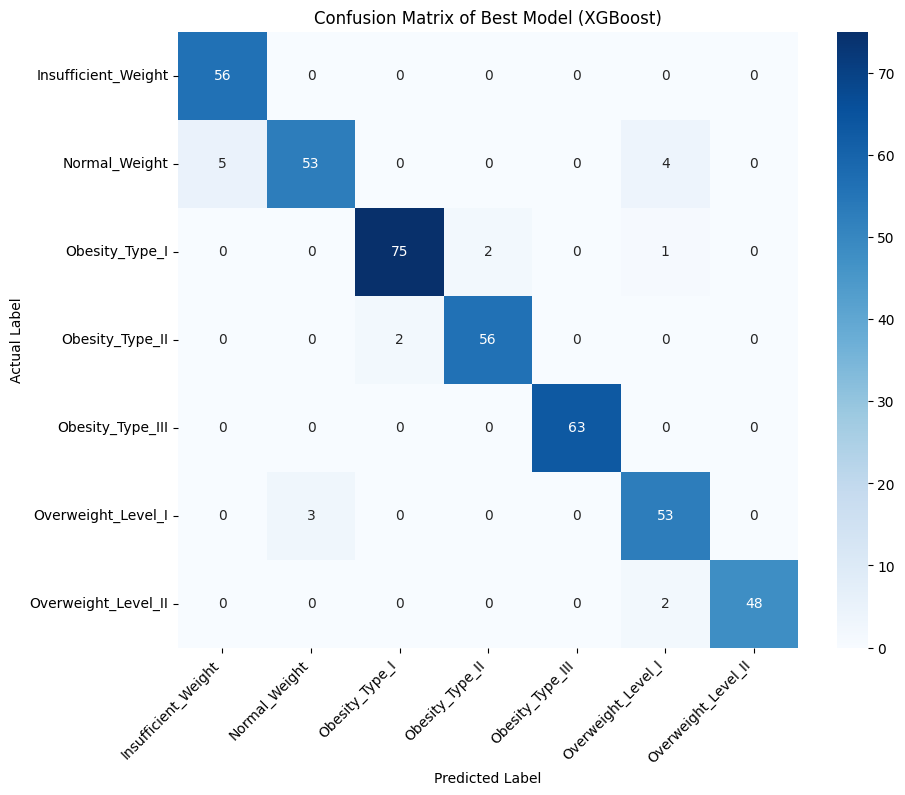

In [7]:
# CONFUSION MATRIX OF BEST MODEL
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

# Get the actual class names (e.g., 'Normal_Weight', 'Obesity_Type_I')
class_names = le_target.classes_

plt.figure(figsize=(10, 8)) 
sns.heatmap(
    confusion_matrix(y_test, y_pred_best), 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names  
)

plt.title(f'Confusion Matrix of Best Model ({best_model_name})')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(rotation=45, ha='right') # Rotate x-labels so they don't overlap
plt.yticks(rotation=0) # Keep y-labels straight
plt.show()

In [8]:
# CLASSIFICATION REPORT OF BEST MODEL
target_names = le_target.inverse_transform(np.unique(y))
print(f"\t--- Classification Report for {best_model_name} ---")
print(classification_report(y_test, y_pred_best, target_names=target_names, digits=6))

	--- Classification Report for XGBoost ---
                     precision    recall  f1-score   support

Insufficient_Weight   0.918033  1.000000  0.957265        56
      Normal_Weight   0.946429  0.854839  0.898305        62
     Obesity_Type_I   0.974026  0.961538  0.967742        78
    Obesity_Type_II   0.965517  0.965517  0.965517        58
   Obesity_Type_III   1.000000  1.000000  1.000000        63
 Overweight_Level_I   0.883333  0.946429  0.913793        56
Overweight_Level_II   1.000000  0.960000  0.979592        50

           accuracy                       0.955083       423
          macro avg   0.955334  0.955475  0.954602       423
       weighted avg   0.956334  0.955083  0.954935       423



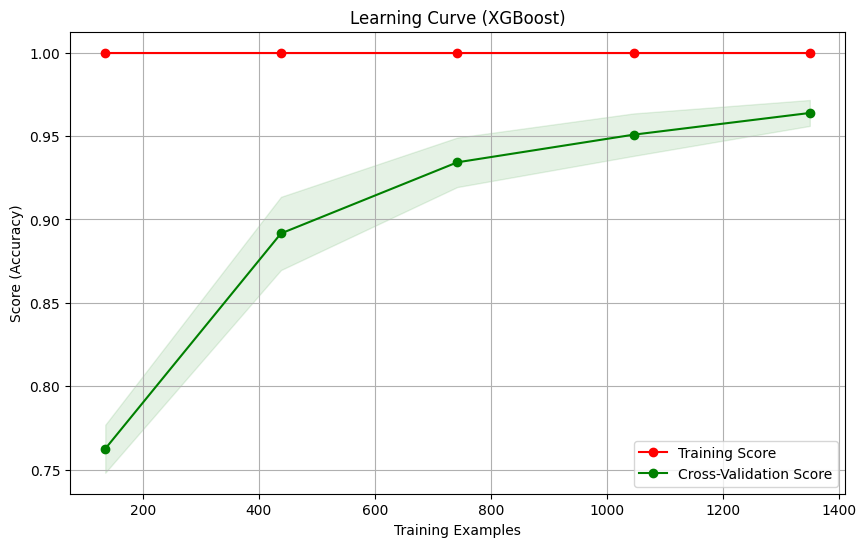

In [9]:
# OVERFITTING & UNDERFITTING (Stability)

def plot_learning_curve(estimator, title, X, y, cv=5):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score (Accuracy)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()

# Check Stability of our Best Model (or Ridge for baseline)
plot_learning_curve(best_model, f"Learning Curve ({best_model_name})", X_train, y_train)


In [10]:
# RIDGE REGRESSION (Linear Baseline)
print("\n--- Ridge Regression Stability Check ---")
ridge_model = RidgeClassifier(alpha=1.0) 
ridge_model.fit(X_train, y_train)

# Test vs CV
y_pred_ridge = ridge_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_ridge)
cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=10)

print(f"Ridge Test Accuracy: {test_acc:.2%}")
print(f"Ridge CV Mean Accuracy: {cv_scores.mean():.2%}")

if abs(test_acc - cv_scores.mean()) < 0.05:
    print(">> DIAGNOSIS: Model is STABLE (Low Variance).")
else:
    print(">> DIAGNOSIS: Model shows signs of instability.")


--- Ridge Regression Stability Check ---
Ridge Test Accuracy: 62.88%
Ridge CV Mean Accuracy: 61.43%
>> DIAGNOSIS: Model is STABLE (Low Variance).


In [11]:
# GRID SEARCH (Hyperparameter Optimization)
# This process may take a minute as we test different combinations
print("\n--- Starting Grid Search for XGBoost ---")

# 1. Define the "Search Space"
# We test a mix of simple parameters (low depth) and complex ones (high depth)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Speed of learning
    'max_depth': [3, 6, 10],            # Complexity of the tree
    'n_estimators': [100, 200],         # Number of trees (Study rounds)
    'subsample': [0.8, 1.0]             # Fraction of data used (Anti-overfitting)
}

# 2. Initialize the Base Model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# 3. Setup Grid Search
# cv=3 means we test each combo 3 times to ensure stability
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# 4. Run the Search (Train on Training Data Only)
grid.fit(X_train, y_train)

# 5. Output the Winner
print(f"\n>> BEST PARAMETERS FOUND: {grid.best_params_}")
print(f">> Best Validation Accuracy (during training): {grid.best_score_:.2%}")


--- Starting Grid Search for XGBoost ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits

>> BEST PARAMETERS FOUND: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
>> Best Validation Accuracy (during training): 96.27%


In [12]:
# MODEL REFINEMENT
print("\n--- Final Evaluation of Optimized Model ---")

# 1. Extract the Best Model from the Grid Search
best_xgb = grid.best_estimator_

# 2. Predict on the Test Set (The Final Exam)
y_pred_refined = best_xgb.predict(X_test)

# 3. Generate the Final Classification Report
# We recover the original class names (e.g., 'Obesity_Type_I') for readability
target_names = le_target.inverse_transform(np.unique(y_test))

print(f"Optimized Model Performance on Test Data:")
print(classification_report(y_test, y_pred_refined, target_names=target_names, digits=6))

# Check to see improvement
final_acc = accuracy_score(y_test, y_pred_refined)
print(f"Final Accuracy: {final_acc:.4%}")


--- Final Evaluation of Optimized Model ---
Optimized Model Performance on Test Data:
                     precision    recall  f1-score   support

Insufficient_Weight   0.933333  1.000000  0.965517        56
      Normal_Weight   0.946429  0.854839  0.898305        62
     Obesity_Type_I   0.974026  0.961538  0.967742        78
    Obesity_Type_II   0.965517  0.965517  0.965517        58
   Obesity_Type_III   1.000000  1.000000  1.000000        63
 Overweight_Level_I   0.868852  0.946429  0.905983        56
Overweight_Level_II   1.000000  0.960000  0.979592        50

           accuracy                       0.955083       423
          macro avg   0.955451  0.955475  0.954665       423
       weighted avg   0.956442  0.955083  0.954994       423

Final Accuracy: 95.5083%


C:\Users\farih\AppData\Local\Temp\ipykernel_23652\1969788320.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Accuracy', y='Model', data=final_results_df, palette=colors)


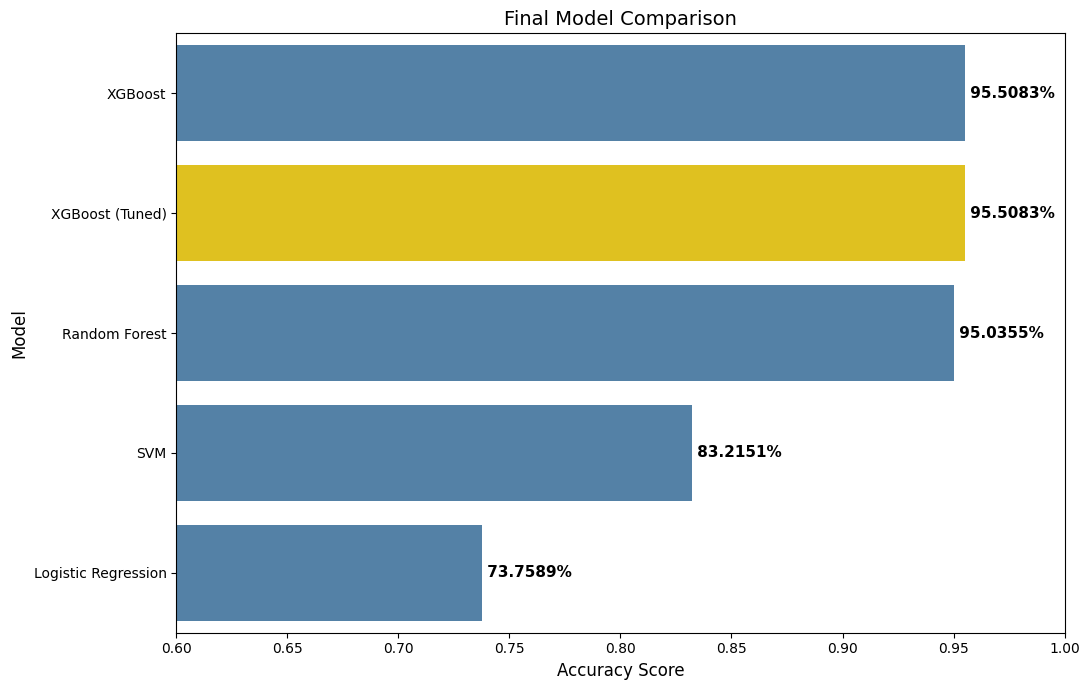

In [13]:
# FINAL PERFORMANCE SUMMARY

# Re-calculate scores for the base 4 models
clean_results = []

for name, model in models.items():
    # Predict & Score
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    clean_results.append({'Model': name, 'Accuracy': acc})

# Add the Tuned Model
clean_results.append({'Model': 'XGBoost (Tuned)', 'Accuracy': final_acc})

# Create DataFrame & Sort
final_results_df = pd.DataFrame(clean_results).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(11, 7))

# Color logic: Gold for Tuned, Blue for others
colors = ['gold' if 'Tuned' in x else 'steelblue' for x in final_results_df['Model']]

ax = sns.barplot(x='Accuracy', y='Model', data=final_results_df, palette=colors)

plt.xlim(0.6, 1.0)
plt.title('Final Model Comparison', fontsize=14)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)


for i, (index, row) in enumerate(final_results_df.iterrows()):
    ax.text(row.Accuracy, i, f' {row.Accuracy:.4%}', 
            color='black', ha="left", va="center", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()